## Problems

### Conversion
1.	Is it possible to predict customer conversion (from viewing to purchasing)?
2.	Can we identify “new customers”? If yes then what is the best strategy to work with them?
3.	What are the top features that define customer conversion?
4.	Can we explain and visualize the predictive model for customer conversion on a journey and at a session level?
5.	Is there a pattern and trend across product types regarding the conversion event?

### Personalization
1.	Can we personalize the experience from customer-product interactions?
2.	Does the product catalogue information help in improving customer experience?
3.	Can personalized shopping experience be predictively modeled?
4.	Can we apply transfer learning from other E-commerce data sets to our local data set?

## Preprocessing

In [2]:
from groupby_user_conversion import GroupBy, FeatureSelection, Evaluation

In [3]:
g = GroupBy('raw_data.json')
preprocessed_data = g.preprocessing_for_bin_class()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [4]:
# Select features
new_features = FeatureSelection.by_coorelation(preprocessed_data['features'], debug=True)
new_features = FeatureSelection.by_permutation_importance(x=new_features, y=preprocessed_data['label'], debug=True)

Feature "totalAddToCarts" is highly related to "totalAddToCartRevenue". Remove "totalAddToCarts"
Feature "uniqueAddToCarts" is highly related to "totalAddToCartRevenue". Remove "uniqueAddToCarts"
Feature "uniqueViewProducts" is highly related to "totalViewProductRevenue". Remove "uniqueViewProducts"
Feature "totalViewProducts" is highly related to "totalViewProductRevenue". Remove "totalViewProducts"
Feature "events" is highly related to "uniqueViewProducts". Remove "events"
Feature "uniqueRefinements" is highly related to "uniqueNavigations". Remove "uniqueRefinements"
Feature "sessionDuration" is highly related to "timeOnSiteSeconds". Remove "sessionDuration"
Feature "totalRefinements" is highly related to "uniqueRefinements". Remove "totalRefinements"
Feature "totalSearches" is highly related to "events". Remove "totalSearches"
Feature "source" is highly related to "has_campaign". Remove "source"
28
              score                  feature
feature 1  0.111520  totalViewProductRe

## XGBoost Model Training

In [14]:
xgb_model, test_x, test_y = GroupBy.train_xgb_bin_class(new_features, preprocessed_data['label'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [25]:
from groupby_user_conversion import classification_report
import pandas as pd

predictions = xgb_model.predict(test_x)
pd.DataFrame(classification_report(test_y, predictions, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.970744,0.725232,0.950735,0.847988,0.949635
recall,0.975500,0.687454,0.950735,0.831477,0.950735
f1-score,0.973116,0.705838,0.950735,0.839477,0.950136
support,14490.000000,1363.000000,0.950735,15853.000000,15853.000000


## Sequential Model Training

In [6]:
preprocessed_data_for_lstm = g.preprocessing_for_sequence_model(num_of_events=30)
lstm_model, test_x, test_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'])

Epoch 1/150
27/27 [==============================] - 24s 76ms/step - loss: 0.6819 - recall: 0.7498 - val_loss: 0.6471 - val_recall: 0.8974
Epoch 2/150
27/27 [==============================] - 0s 11ms/step - loss: 0.6337 - recall: 0.9037 - val_loss: 0.5854 - val_recall: 0.9113
Epoch 3/150
27/27 [==============================] - 0s 11ms/step - loss: 0.5666 - recall: 0.9130 - val_loss: 0.5038 - val_recall: 0.9157
Epoch 4/150
27/27 [==============================] - 0s 11ms/step - loss: 0.4829 - recall: 0.9164 - val_loss: 0.4226 - val_recall: 0.9177
Epoch 5/150
27/27 [==============================] - 0s 10ms/step - loss: 0.4093 - recall: 0.9179 - val_loss: 0.3593 - val_recall: 0.9187
Epoch 6/150
27/27 [==============================] - 0s 10ms/step - loss: 0.3397 - recall: 0.9190 - val_loss: 0.3167 - val_recall: 0.9196
Epoch 7/150
27/27 [==============================] - 0s 10ms/step - loss: 0.3052 - recall: 0.9197 - val_loss: 0.2901 - val_recall: 0.9201
Epoch 8/150
27/27 [==============

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


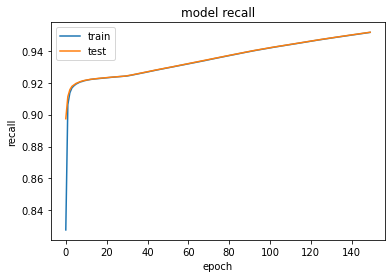

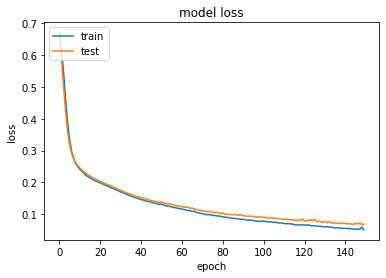

In [7]:
Evaluation.plot_history(lstm_model.history)

In [13]:
Evaluation.evaluate_on_test(test_x, test_y, lstm_model)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.976771
Precision: 0.944515
Recall: 0.726479
F1 score: 0.821272
